In [1]:
import pandas as pd
import re
import numpy as np
from gensim.models import FastText

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In [2]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

In [5]:
# Load and preprocess chat data
def parse_chat(file_path):
    pattern = re.compile(r"^(\d{1,2}[\/\.-]\d{1,2}[\/\.-]\d{2,4}),? (\d{1,2}:\d{2}(?:\s?[APMapm]{2})?) - ([^:]+): (.*)")
    data = []
    with open(file_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()
    
    for line in lines:
        match = pattern.match(line.strip())
        if match:
            date, time, contact, message = match.groups()
            data.append([date, time, contact, message])
    
    df = pd.DataFrame(data, columns=['date', 'time', 'contact', 'message'])
    df['date'] = pd.to_datetime(df['date'], errors='coerce', dayfirst=True)
    return df

In [6]:
df = parse_chat(r"C:\Users\HP\Documents\DL\NLP\WhatsApp Chat with CSDS Official Group 2022-26\WhatsApp Chat with CSDS Official Group 2022-26.txt")


In [7]:
df

,date,time,contact,message
0,2023-08-18,9:15 am,Vijayalaxmi Mam,<Media omitted>
1,2023-08-18,9:15 am,Vijayalaxmi Mam,Students follow this updated time table
2,2023-08-20,8:25 am,Vijayalaxmi Mam,<Media omitted>
3,2023-08-20,8:26 am,Vijayalaxmi Mam,<Media omitted>
4,2023-08-21,8:45 am,Vijayalaxmi Mam,<Media omitted>
...,...,...,...,...
734,2025-02-28,5:18 pm,Tarini Pattnaik Sir OS,<Media omitted>
735,2025-03-11,5:01 pm,Adv.Python Sir,<Media omitted>
736,2025-03-11,5:02 pm,Adv.Python Sir,<Media omitted>
737,2025-03-11,7:25 pm,Tarini Pattnaik Sir OS,🚀 ANNOUNCEMENT: TECHXERA's SYNTHARA 1.0 is HER...


In [8]:
df = df[df["message"] != "<Media omitted>"]

In [9]:
df

,date,time,contact,message
1,2023-08-18,9:15 am,Vijayalaxmi Mam,Students follow this updated time table
6,2023-08-24,10:18 am,Vijayalaxmi Mam,Try to clear your dues ASAP
7,2023-08-24,11:52 pm,Vijayalaxmi Mam,*Seventh edition of India Mobile Congress (IMC...
8,2023-08-25,1:18 pm,Vijayalaxmi Mam,"On request by some of the students, ur registr..."
9,2023-08-25,8:35 pm,Vijayalaxmi Mam,*Important: Smart India Hackathon 2023 Awarene...
...,...,...,...,...
726,2025-02-22,12:54 pm,HOD,You are directed to attend the employability c...
728,2025-02-22,6:24 pm,HOD,This is for the information of all concerned t...
729,2025-02-22,9:59 pm,Tarini Pattnaik Sir OS,"Dear [Training and Placement Officer],"
730,2025-02-23,11:11 am,Library Mam,*Notice*


In [10]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize VADER
analyzer = SentimentIntensityAnalyzer()

# Function to classify sentiment
def get_sentiment_vader(text):
    if not isinstance(text, str) or text.strip() == "":
        return "neutral"  # Default for empty text

    score = analyzer.polarity_scores(text)['compound']  # Get compound sentiment score
    
    if score > 0.05:
        return "positive"
    elif score < -0.05:
        return "negative"
    else:
        return "neutral"

# Apply function to processed_message
df['sentiment_level'] = df['message'].apply(get_sentiment_vader)


C:\Users\HP\AppData\Local\Temp\ipykernel_6444\2910930458.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment_level'] = df['message'].apply(get_sentiment_vader)


In [11]:
df

,date,time,contact,message,sentiment_level
1,2023-08-18,9:15 am,Vijayalaxmi Mam,Students follow this updated time table,neutral
6,2023-08-24,10:18 am,Vijayalaxmi Mam,Try to clear your dues ASAP,positive
7,2023-08-24,11:52 pm,Vijayalaxmi Mam,*Seventh edition of India Mobile Congress (IMC...,positive
8,2023-08-25,1:18 pm,Vijayalaxmi Mam,"On request by some of the students, ur registr...",negative
9,2023-08-25,8:35 pm,Vijayalaxmi Mam,*Important: Smart India Hackathon 2023 Awarene...,positive
...,...,...,...,...,...
726,2025-02-22,12:54 pm,HOD,You are directed to attend the employability c...,neutral
728,2025-02-22,6:24 pm,HOD,This is for the information of all concerned t...,negative
729,2025-02-22,9:59 pm,Tarini Pattnaik Sir OS,"Dear [Training and Placement Officer],",positive
730,2025-02-23,11:11 am,Library Mam,*Notice*,neutral


In [12]:
df['sentiment_level'].unique()

array(['neutral', 'positive', 'negative'], dtype=object)

In [13]:
# Text preprocessing
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text.lower())
    words = [word for word in words if word.isalnum() and word not in stop_words]
    return words

In [14]:
df['processed_message'] = df['message'].apply(preprocess_text)

C:\Users\HP\AppData\Local\Temp\ipykernel_6444\4264624158.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['processed_message'] = df['message'].apply(preprocess_text)


In [15]:
# df['sentiment_level'] = df['processed_message'].apply(get_sentiment)

In [16]:
df.head()

,date,time,contact,message,sentiment_level,processed_message
1,2023-08-18,9:15 am,Vijayalaxmi Mam,Students follow this updated time table,neutral,"[students, follow, updated, time, table]"
6,2023-08-24,10:18 am,Vijayalaxmi Mam,Try to clear your dues ASAP,positive,"[try, clear, dues, asap]"
7,2023-08-24,11:52 pm,Vijayalaxmi Mam,*Seventh edition of India Mobile Congress (IMC...,positive,"[seventh, edition, india, mobile, congress, im..."
8,2023-08-25,1:18 pm,Vijayalaxmi Mam,"On request by some of the students, ur registr...",negative,"[request, students, ur, registration, dead, li..."
9,2023-08-25,8:35 pm,Vijayalaxmi Mam,*Important: Smart India Hackathon 2023 Awarene...,positive,"[important, smart, india, hackathon, 2023, awa..."


In [17]:
# Convert sentiment to integers
sentiment_map = {'negative': 0, 'neutral': 1, 'positive': 2}
df['label'] = df['sentiment_level'].map(sentiment_map)

C:\Users\HP\AppData\Local\Temp\ipykernel_6444\3935516722.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = df['sentiment_level'].map(sentiment_map)


In [18]:
# Convert list of tokens into strings for tokenizer
texts = [' '.join(tokens) for tokens in df['processed_message']]
labels = df['label'].values

In [19]:
# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

In [20]:
# Padding
X = pad_sequences(sequences, padding='post')
y = np.array(labels)

In [21]:
# Define RNN model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=16),
    tf.keras.layers.SimpleRNN(64, return_sequences=True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax') 
])

In [22]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [23]:
his = model.fit(X, y, epochs=22, batch_size=16, verbose=1, validation_split=0.2)

Epoch 1/22
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.4167 - loss: 1.0420 - val_accuracy: 0.6912 - val_loss: 0.7754
Epoch 2/22
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.6163 - loss: 0.7878 - val_accuracy: 0.7353 - val_loss: 0.6678
Epoch 3/22
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8161 - loss: 0.4832 - val_accuracy: 0.7500 - val_loss: 0.6353
Epoch 4/22
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9336 - loss: 0.2500 - val_accuracy: 0.7647 - val_loss: 0.6551
Epoch 5/22
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9773 - loss: 0.1173 - val_accuracy: 0.7353 - val_loss: 0.7133
Epoch 6/22
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9879 - loss: 0.0641 - val_accuracy: 0.7206 - val_loss: 0.8151
Epoch 7/22
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 1.0000 - loss: 0.0279 - val_accuracy: 0.7794 - val_loss: 0.8881
Epoch 8/22
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 1.0000 - loss: 0.0150 - val_accuracy: 0.7353 - v

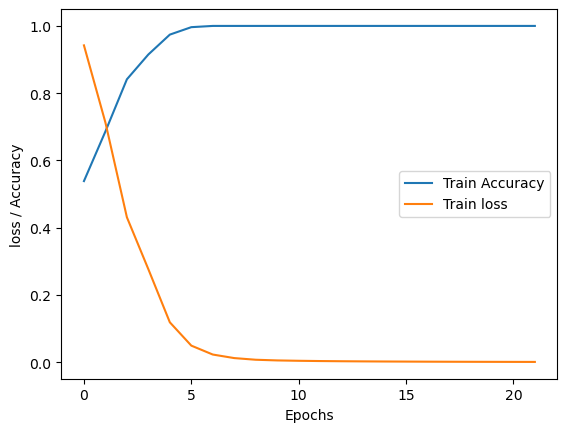

In [24]:
# Plot training history
plt.plot(his.history['accuracy'], label='Train Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.plot(his.history['loss'], label='Train loss')

plt.xlabel('Epochs')
plt.ylabel('loss / Accuracy')
plt.legend()
plt.show()


In [26]:
# # Predict on a new message
# def predict_sentiment(text_list):
#     text = ' '.join(text_list)
#     seq = tokenizer.texts_to_sequences([text])
#     padded = pad_sequences(seq, maxlen=X.shape[1], padding='post')
#     pred = model.predict(padded)
#     label_idx = np.argmax(pred)
#     label_map = {v: k for k, v in sentiment_map.items()}
#     print(f"Predicted Sentiment: {label_map[label_idx]}")